# Black Friday Sales Dataset (Analytics Vidhya contest)

### Problem statement
To understand the customer purchase behavior (specifically, purchase amount) against various products of different categories, and build a model to predict the purchase amount of customer against various products which will help to create personalized offer for customers against different products.

### Attribute information
1. User_ID: User ID
2. Product_ID: Product ID
3. Gender: Sex of User
4. Age: Age in bins
5. Occupation: Occupation (Masked)
6. City_Category:	Category of the City (A,B,C)
7. Stay_In_Current_City_Years:	Number of years stay in current city
8. Marital_Status:	Marital Status
9. Product_Category_1:	Product Category (Masked)
10. Product_Category_2:	Product may belongs to other category also (Masked)
11. Product_Category_3:	Product may belongs to other category also (Masked)
12. Purchase:	Purchase Amount (Target Variable)

### Result
- The purchase prediction with a RMSE score = 2429.7891689172
- **Rank 20 out of 13791 participants (0.14%)** --*Last update: 2018-12-31*
- Leaderboard: https://datahack.analyticsvidhya.com/contest/black-friday/lb

### Reference
1. https://datahack.analyticsvidhya.com/contest/black-friday/
<br>
<br>
<br>

In [1]:
from IPython.display import HTML

display(HTML('<style>.prompt{width: 0px; min-width: 0px; visibility: collapse}</style>'))

# Reference: http://blog.nextgenetics.net/?e=102
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to show/hide the codes"></form>''')

In [2]:
import warnings
warnings.filterwarnings(action='ignore')

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, BatchNormalization, ELU, Dropout, Embedding, Input, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

%matplotlib inline

In [4]:
plt.style.use('seaborn-muted')
sns.set_style('whitegrid')

import matplotlib as mpl
# mpl.rcParams['figure.dpi'] = 100
mpl.rcParams['figure.figsize'] = (11, 8)
mpl.rcParams['figure.titlesize'] = 'large'
mpl.rcParams['legend.fontsize'] = 'medium'
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12

## Load data

In [5]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

After loading the data, we can quickly take a snapshot of the train dataset and summary of the data structure.

In [6]:
train.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,7969


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550068 entries, 0 to 550067
Data columns (total 12 columns):
User_ID                       550068 non-null int64
Product_ID                    550068 non-null object
Gender                        550068 non-null object
Age                           550068 non-null object
Occupation                    550068 non-null int64
City_Category                 550068 non-null object
Stay_In_Current_City_Years    550068 non-null object
Marital_Status                550068 non-null int64
Product_Category_1            550068 non-null int64
Product_Category_2            376430 non-null float64
Product_Category_3            166821 non-null float64
Purchase                      550068 non-null int64
dtypes: float64(2), int64(5), object(5)
memory usage: 50.4+ MB


***
- Data is more than half of a million, containing both object and numeric values
- Some columns could be convert to numeric for better processing (e.g. Product_ID, Age, Stay_In_Current_City_Years, etc.)
- "Product_Category_2" and "Product_Category_3" have missing values that should be dealt with before performing the training
***

## Exploratory feature analysis

Let's see what is the distribution of the sex of users.

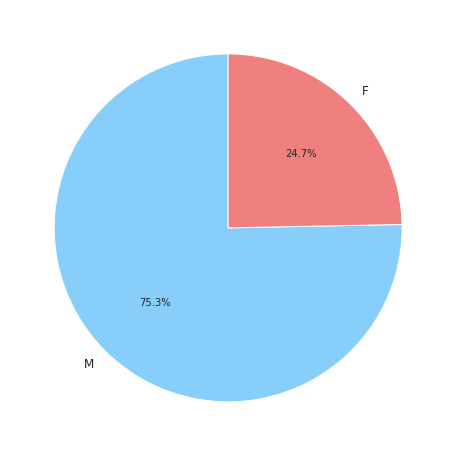

In [8]:
plt.pie(train['Gender'].value_counts(), labels=train['Gender'].value_counts().index,
        colors=['lightskyblue','lightcoral'], autopct='%1.1f%%', startangle=90)
plt.show()

***
- Male user count is roughly 3x as much as the Female user count.
***

Also take a look at the distribution across the age groups.

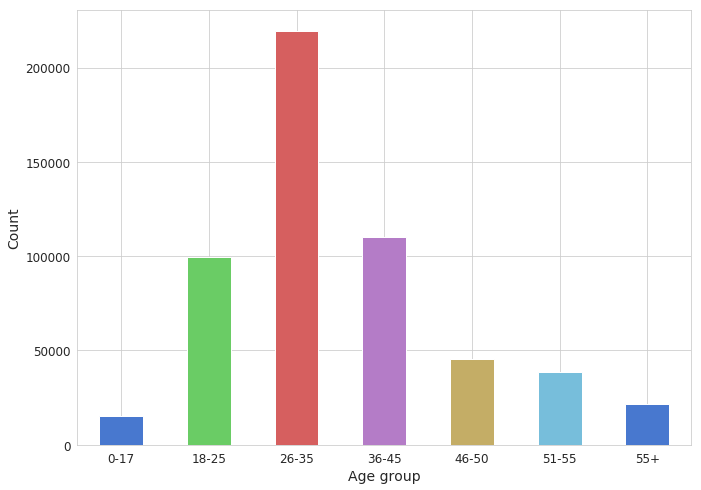

In [9]:
train['Age'].value_counts().sort_index().plot.bar(rot=0)
plt.xlabel('Age group')
plt.ylabel('Count')
plt.show()

***
- People with ages between 26-35 are the primarly customers, following by the groups of 18-25 and 36-45.
- Age 0-17 made the least purchase as expected, since they are typically associated w/ less economic freedom.
***

Now let's look into more details in statistics by using boxplots.

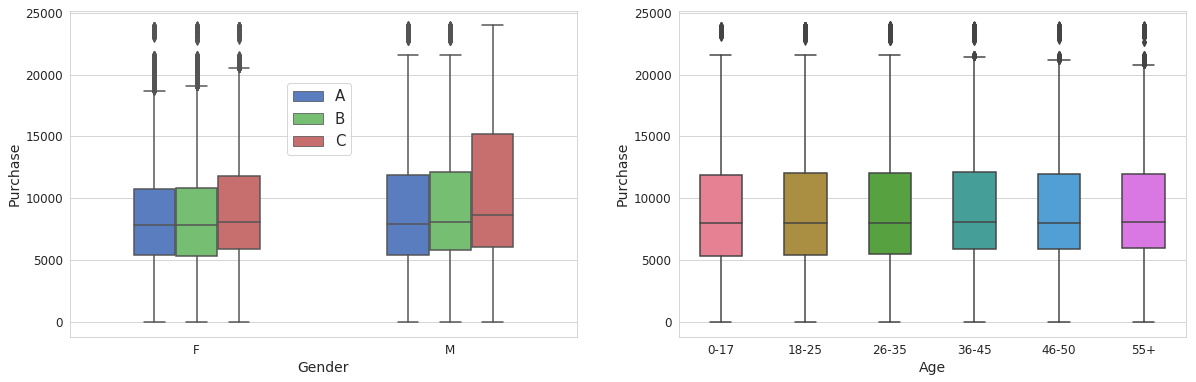

In [10]:
figs, axs = plt.subplots(1,2, figsize=(20,6))
sns.boxplot(x='Gender', y='Purchase', data=train, hue='City_Category', hue_order=['A','B','C'], 
            width=0.5, ax=axs[0])
axs[0].legend(bbox_to_anchor=(0.57, 0.8), fontsize=15)

sns.boxplot(x='Age', y='Purchase', data=train,
            order=['0-17','18-25','26-35','36-45','46-50','55+'], palette=sns.color_palette('husl'),
            width=0.5, ax=axs[1])
plt.show()

***
- For all cities, the pruchase distributions are skewed to the bottom, and the **mean purchase amount is about the same level regardless of gender**.
- **Male seems to have generally larger amount of purchase in all cities.**
- Female data appear to have more outliers, i.e. higher purchase amounts that are far away from the majority. 
- Interestingly, in terms of purchase amount, **age seems irrelevant** even though age 0-17 indeed has the lowest average value.
***

How about occupation? I expect to see some occupations may tend to make more purchase amount compared to others.

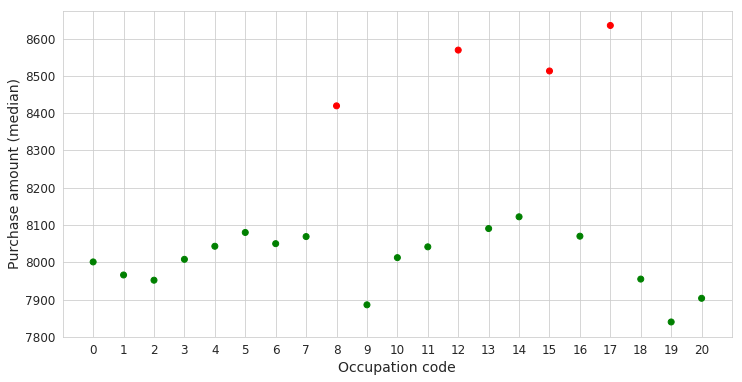

In [11]:
purchase_by_occup = train.groupby(['Occupation'])['Purchase'].median().sort_values(ascending=False)
plt.figure(figsize=(12,6))
color = ['red' if p>purchase_by_occup.values.mean()+purchase_by_occup.values.std() 
         else 'green' for p in purchase_by_occup.values]
plt.scatter(purchase_by_occup.index, purchase_by_occup.values, color=color)
plt.xticks(purchase_by_occup.index)
plt.xlabel('Occupation code')
plt.ylabel('Purchase amount (median)')
plt.show()

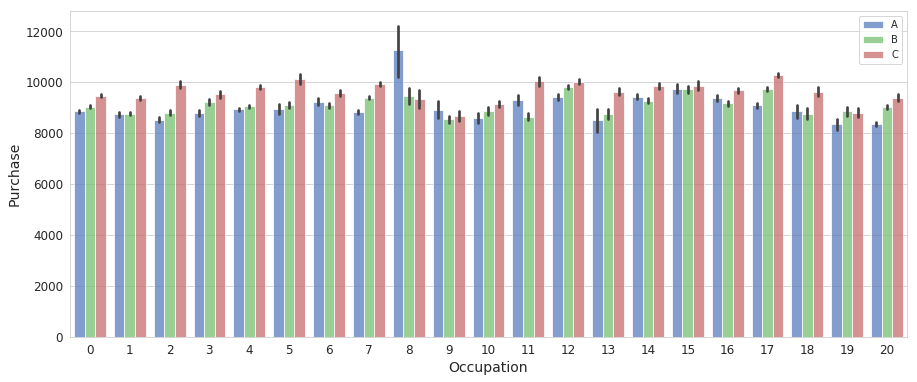

In [12]:
plt.figure(figsize=(15,6))
sns.barplot(x='Occupation', y='Purchase', data=train,
            hue='City_Category', hue_order=['A','B','C'],
            alpha=0.75)

plt.legend(loc='best')
plt.show()

***
- **Ocupation# 8, 12, 15, 17** have the highest median purchase amounts, more than 1 standard deviation away from other occupations
- It is interesting to see that **Ocupation#8 in A city is very different than others.**
- However, the difference in occupations are relatively small, which does not help too much about understanding the purchase behavior.
***

Check the behaviors of different kind of users in different cities.

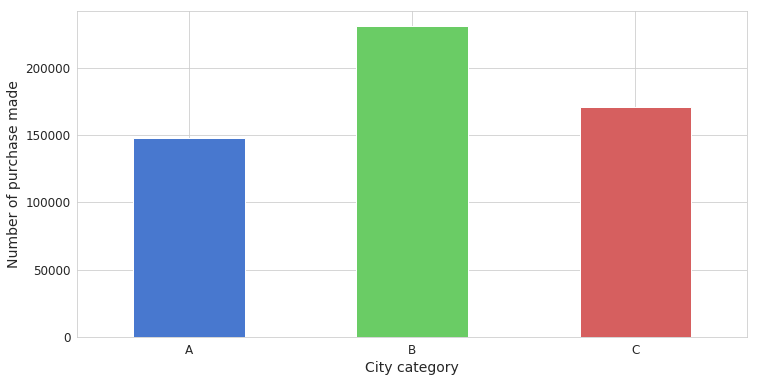

In [13]:
plt.figure(figsize=(12,6))
train['City_Category'].value_counts().sort_index().plot.bar(rot=0)
plt.xlabel('City category')
plt.ylabel('Number of purchase made')
plt.show()

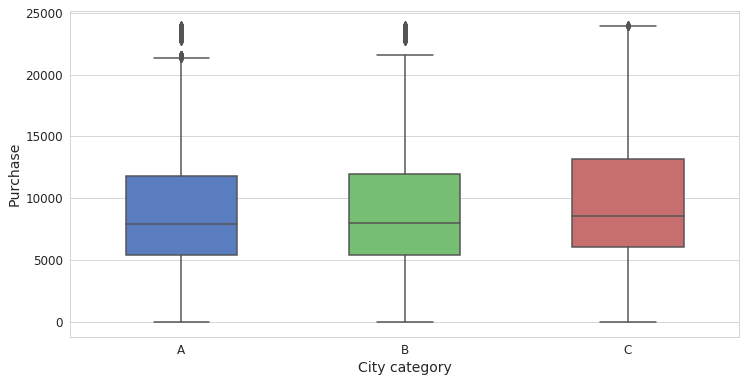

In [14]:
purchase_by_city = train[['City_Category','Purchase']]
plt.figure(figsize=(12,6))
sns.boxplot(x='City_Category', y='Purchase', data=purchase_by_city, width=0.5, order=list('ABC'))
plt.xlabel('City category')
plt.show()

***
- B city appears to have made **the highest purchase count.**
- However, **B city does not have the highest purchase amount**, suggesting that consumer behavior is based on **small quantities with frequent purchase.**
- On the other hand, C city makes the overall largest average purchase amount.
***

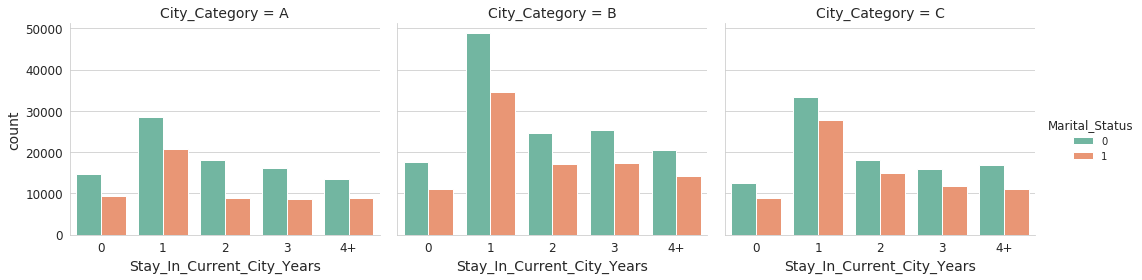

In [15]:
sns.catplot(x='Stay_In_Current_City_Years', order=['0','1','2','3','4+'],
            col='City_Category', col_order=['A','B','C'], hue='Marital_Status', 
            data=train, kind='count', palette='Set2',
            height=4, aspect=1.2)

plt.show()

***
- Most people have only been staying in the current citiy for about 1 year.
- Single people make more purchase than married people.
***

Let's take a look at the correlations between each feature.

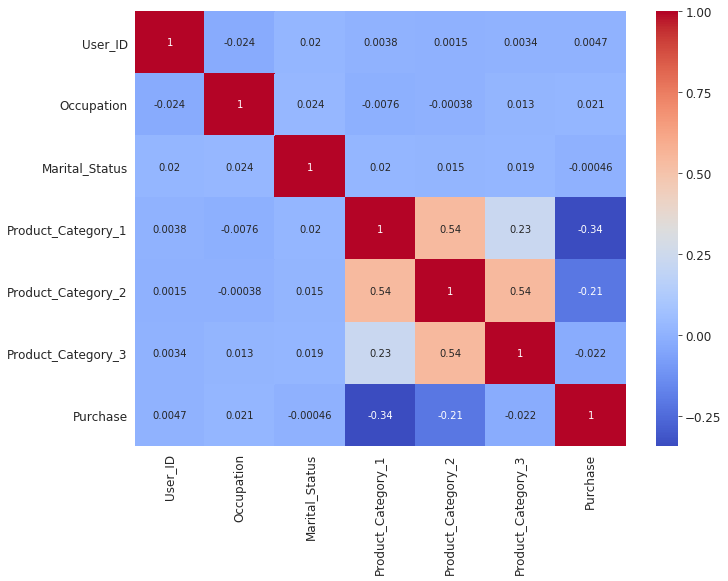

In [16]:
sns.heatmap(train.corr(), cmap='coolwarm', annot=True)

***
- From heatmap we can see that most of the features are not strongly correlated. 
- The feature that shows the strongest correlation is **purchase from pruducts in "Product_Category_1"**.
***

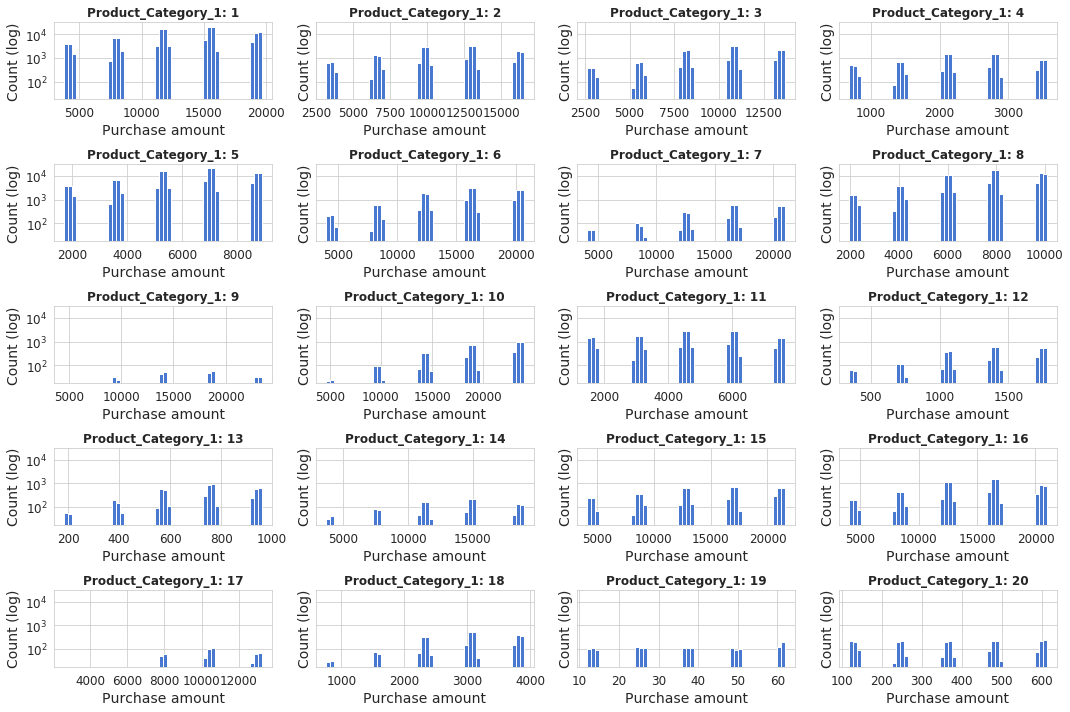

In [17]:
figs, axes = plt.subplots(5, 4, figsize=(15,10), sharey=True)
pc1 = sorted(train['Product_Category_1'].unique())
m = 0

for row in range(5):
    for col in range(4):
        axes[row,col].hist(train.loc[train['Product_Category_1']==pc1[m],'Purchase'], bins=50)
        axes[row,col].set_title('Product_Category_1: {}'.format(pc1[m]), weight='bold')
        axes[row,col].set_xlabel('Purchase amount')
        axes[row,col].set_ylabel('Count (log)')
        axes[row,col].set_yscale('log')
        m += 1
        
plt.tight_layout()
plt.show()

***
- By looking at the histagrm of different product codes in Product_Category_1 **(noted that scales in x-axis are all different)**, data clearly shows that we got commonly **5 groups of purchase amount!** 
- However, there is no simple way to separate them based on other product details nor the customer demographics as shown above.
***

## Feature engineering

- Convert columns with categorical variables into numeric values, e.g. Gender, Years, Ages, etc.
- Handle missing valus in "Product_Category_1", "Product_Category_2", and "Product_Category_3"
- OneHot encoded the "City_Category"
- Prepare nominal variables such as "Product_ID", and "City_Category" for embedding

In [18]:
train['Product_ID'] = train['Product_ID'].apply(lambda x: int(x[1:]))
train['Gender'] = train['Gender'].apply(lambda x: 1 if x=='M' else 0)
train.rename(columns = {'Gender': 'Male'}, inplace=True)
train['Stay_In_Current_City_Years'] = train['Stay_In_Current_City_Years'].apply(lambda x: int(x) if x in ['0','1','2','3'] else 5)

age_dict = {'0-17':  1,
            '18-25': 3,
            '26-35': 4,
            '36-45': 5,
            '46-50': 6,
            '51-55': 7,
            '55+':   9
           }

def age_num_conv(age):
    if age in age_dict:
        return age_dict[age]
    else: None
    
train['Age'] = train['Age'].apply(age_num_conv)

train[['Product_Category_1','Product_Category_2','Product_Category_3']] = \
        train[['Product_Category_1','Product_Category_2','Product_Category_3']].fillna(0)

temp_city = pd.get_dummies(train['City_Category'], drop_first=True)
train = pd.concat([train, temp_city.add_prefix('City_')], axis=1)


Now this is how the dataset looks like after feature engineering.

In [19]:
train.head()

,User_ID,Product_ID,Male,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase,City_B,City_C
0,1000001,69042,0,1,10,A,2,0,3,0.0,0.0,8370,0,0
1,1000001,248942,0,1,10,A,2,0,1,6.0,14.0,15200,0,0
2,1000001,87842,0,1,10,A,2,0,12,0.0,0.0,1422,0,0
3,1000001,85442,0,1,10,A,2,0,12,14.0,0.0,1057,0,0
4,1000002,285442,1,9,16,C,5,0,8,0.0,0.0,7969,0,1


## Neural Network

### 1. Prepare datasets

Shuffle the training data and separate the feature columns used for embedding.

In [20]:
train_df = train.sample(frac=1)

drop_col = ['User_ID','Product_ID','Occupation','City_Category',
            'Product_Category_1','Product_Category_2','Product_Category_3',
            'Purchase']
embd_col = ['Product_ID','Occupation','Product_Category_1','Product_Category_2','Product_Category_3']

### 2. Encode categorical variables for embedding

Create a categorical encoder, and select features for embedding.

In [21]:
class CategoricalEncoder():
    
    def __init__(self, series):
        values = series.unique().tolist()
        self.embedding_dict = {value: int_value+1 for int_value, value in enumerate(values,1)}
        self.num_values = len(values) + 1

    def get_mapping(self, value):
        if value in self.embedding_dict:
            return self.embedding_dict[value]
        # If the value was unseen, return 0
        else:
            return 0

In [22]:
for col in embd_col:
    collection_mapping = CategoricalEncoder(train[col])  # map feature only from train dataset
    train_df[col] = train_df[col].apply(collection_mapping.get_mapping).astype('int16')
#     test[col] = test[col].apply(collection_mapping.get_mapping).astype('int16')

Prepare training data and label data.

In [23]:
X_train_main = train_df.drop(drop_col+embd_col, axis=1)

X_train_cat = train_df[embd_col[0]]
X_train_cat2 = train_df[embd_col[1]]
X_train_cat3 = train_df[embd_col[2]]
X_train_pc1 = train_df[embd_col[3]]
X_train_pc2 = train_df[embd_col[4]]
X_train_pc3 = train_df[embd_col[5]]

y_train = train_df[['Purchase']]

### 3. Build the model

Construct a fully connected NN, with embedding layers and 4 hidden layers.

In [24]:
def model_embd(main, cat1, cat2, cat3, pc1, pc2, pc3):
    data_main = main
    data_cat1 = cat1
    data_cat2 = cat2
    data_cat3 = cat3
    data_pc1 = pc1
    data_pc2 = pc2
    data_pc3 = pc3
    
    id_input1 = Input(shape=(1,), dtype='int32', name='id_input1')
    x1 = Embedding(output_dim=32, input_dim=max(data_cat1)+1, input_length=len(data_cat1))(id_input1)
    id_out1 = Flatten()(x1)

    id_input2 = Input(shape=(1,), dtype='int32', name='id_input2')
    x2 = Embedding(output_dim=32, input_dim=max(data_cat2)+1, input_length=len(data_cat2))(id_input2)
    id_out2 = Flatten()(x2)
    
    id_input3 = Input(shape=(1,), dtype='int32', name='id_input3')
    x3 = Embedding(output_dim=2, input_dim=max(data_cat3)+1, input_length=len(data_cat3))(id_input3)
    id_out3 = Flatten()(x3)
    
    id_input4 = Input(shape=(1,), dtype='int32', name='id_input4')
    x4 = Embedding(output_dim=4, input_dim=max(data_pc1)+1, input_length=len(data_pc1))(id_input4)
    id_out4 = Flatten()(x4)
    
    id_input5 = Input(shape=(1,), dtype='int32', name='id_input5')
    x5 = Embedding(output_dim=4, input_dim=max(data_pc2)+1, input_length=len(data_pc2))(id_input5)
    id_out5 = Flatten()(x5)
    
    id_input6 = Input(shape=(1,), dtype='int32', name='id_input6')
    x6 = Embedding(output_dim=4, input_dim=max(data_pc3)+1, input_length=len(data_pc3))(id_input6)
    id_out6 = Flatten()(x6)

    main_input = Input(shape=(data_main.shape[1],), name='main_input')
    main_layer0 = keras.layers.concatenate([main_input, id_out1, id_out2, id_out3, id_out4, id_out5, id_out6])
    main_layer0 = BatchNormalization()(main_layer0)
    main_layer1 = Dense(36, activation="elu")(main_layer0)
    main_layer1 = BatchNormalization()(main_layer1)
    main_layer2 = Dense(36, activation="elu")(main_layer1)
    main_layer2 = BatchNormalization()(main_layer2)
    main_layer3 = Dense(36, activation="elu")(main_layer2)
    main_layer3 = BatchNormalization()(main_layer3)
    main_output = Dense(1, name='main_output')(main_layer3)

    model = Model(inputs=[main_input, id_input1, id_input2, id_input3, id_input4, id_input5, id_input6], 
                  outputs=[main_output])

    model.compile(loss='mse',
                  optimizer=keras.optimizers.Adam(lr=0.001),
                  metrics=['mse'])
                           
    return model

In [25]:
model = model_embd(X_train_main,
                   X_train_cat, X_train_cat2, X_train_cat3,
                   X_train_pc1, X_train_pc2, X_train_pc3)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


Take a look at the model structure.

In [26]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
id_input1 (InputLayer)          (None, 1)            0                                            
__________________________________________________________________________________________________
id_input2 (InputLayer)          (None, 1)            0                                            
__________________________________________________________________________________________________
id_input3 (InputLayer)          (None, 1)            0                                            
__________________________________________________________________________________________________
id_input4 (InputLayer)          (None, 1)            0                                            
__________________________________________________________________________________________________
id_input5 

### 4. Fit the model

Use early stopping as a mean of regularization.

In [27]:
early_stopping = EarlyStopping(patience=5)

# filepath='model-{epoch:02d}-{val_mean_squared_error:.2f}.hdf5'
# check_point = ModelCheckpoint(filepath, monitor='val_mean_squared_error', verbose=0, save_best_only=True)

In [28]:
EPOCHS = 100

history = model.fit([X_train_main, X_train_cat, X_train_cat2, X_train_cat3, X_train_pc1, X_train_pc2, X_train_pc3], 
                     y_train,
                     epochs=EPOCHS,
                     validation_split = 0.2,
                     verbose=1, 
                     shuffle=True,
                     callbacks=[early_stopping]) #check_point])


Train on 440054 samples, validate on 110014 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/100
440054/440054 [==============================] - 59s 133us/sample - loss: 57204885.4537 - mean_squared_error: 57204996.0000 - val_loss: 8838555.3280 - val_mean_squared_error: 8838557.0000
Epoch 2/100
440054/440054 [==============================] - 58s 131us/sample - loss: 6831098.1267 - mean_squared_error: 6831132.0000 - val_loss: 5967322.7336 - val_mean_squared_error: 5967324.5000
Epoch 3/100
440054/440054 [==============================] - 58s 131us/sample - loss: 6425961.6909 - mean_squared_error: 6425970.0000 - val_loss: 5927907.5124 - val_mean_squared_error: 5927903.0000
Epoch 4/100
440054/440054 [==============================] - 57s 130us/sample - loss: 6233640.2764 - mean_squared_error: 6233634.0000 - val_loss: 5848051.6532 - val_mean_squared_error: 5848052.0000
Epoch 5/100
440054/440054 [==============================] - 57s 131us/sample - loss: 6095162.8717 - mean_

### 5. Output the best RMSE obtained

Review the history of the NN training and highlight the lowest RMSE score for the validation set.

In [29]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist['RMSE'] = np.sqrt(hist['mean_squared_error'])
hist['val_RMSE'] = np.sqrt(hist['val_mean_squared_error'])
hist.loc[[hist['val_RMSE'].idxmin()]][['val_mean_squared_error' ,'val_RMSE']]

,val_mean_squared_error,val_RMSE
6,5808486.0,2410.080082


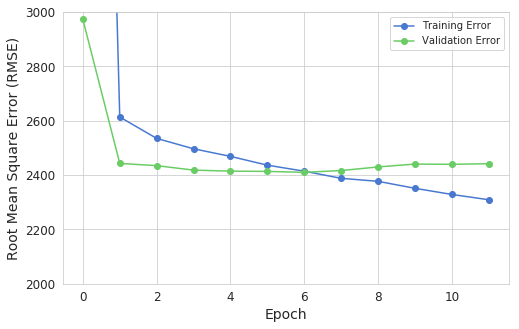

In [30]:
plt.figure(figsize=(8,5))

plt.plot(hist['epoch'], hist['RMSE'], '-o',
         label='Training Error')
plt.plot(hist['epoch'], hist['val_RMSE'], '-o',
         label='Validation Error')
plt.xlabel('Epoch')
plt.ylabel('Root Mean Square Error (RMSE)')
plt.ylim(2000, 3000)
plt.legend()
plt.show()

**Submission RMSE score: 2429.78916**